# Gas Turbine NOx Emission Analysis

## Problem Statement

Gas turbines are widely used in industrial energy systems. One of the major environmental concerns in combustion systems is the formation of nitrogen oxides (NOx).

The objective of this project is to:

- Understand the drivers of NOx emissions
- Identify potential non-linear relationships
- Prepare the dataset for predictive modeling
- Establish a foundation for emission-aware optimization

This notebook focuses on Exploratory Data Analysis (EDA) and data preparation.


In [1]:
import pandas as pd
import glob


files = glob.glob("../data/*.csv")

df_list = [pd.read_csv(file) for file in files]

df = pd.concat(df_list, ignore_index=True)

df.shape

(36733, 11)

## Dataset Overview

The dataset contains industrial sensor measurements from gas turbine systems, including:

- Ambient conditions (temperature, pressure, humidity)
- Turbine operating parameters
- Emission measurements (CO and NOx)

Before modeling, it is essential to:
- Verify data integrity
- Check for duplicates
- Investigate feature distributions
- Analyze potential skewness

In [2]:
df.info()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


np.int64(7)

## Data Quality Check

Observations:

- No missing values detected.
- Only a small number of duplicate rows were found and removed.
- Dataset size after cleaning: 36,726 records.

This ensures that cross-validation results will not be biased by duplicated samples.


In [3]:
df = df.drop_duplicates()

df.shape

(36726, 11)

In [4]:
corr_matrix = df.corr()

corr_matrix['NOX'].sort_values(ascending=False)

NOX     1.000000
CO      0.340580
AP      0.191700
AH      0.164931
TAT    -0.092711
TEY    -0.116150
CDP    -0.171247
AFDP   -0.188138
GTEP   -0.201617
TIT    -0.213869
AT     -0.558095
Name: NOX, dtype: float64

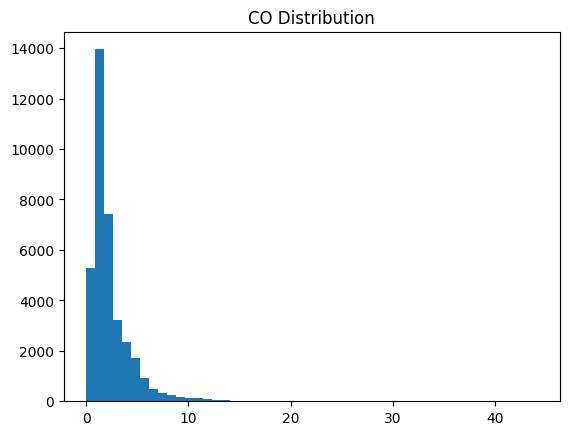

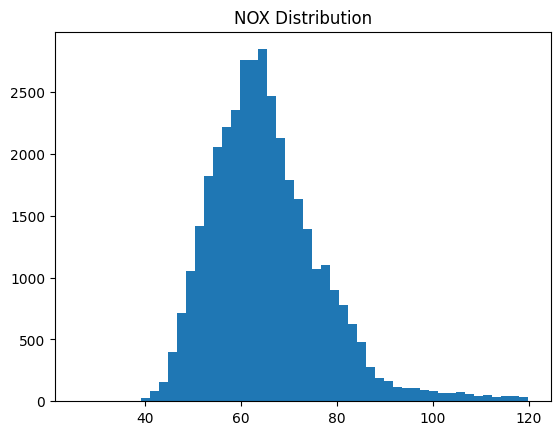

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['CO'], bins=50)
plt.title("CO Distribution")
plt.show()

plt.figure()
plt.hist(df['NOX'], bins=50)
plt.title("NOX Distribution")
plt.show()

In [6]:
df['CO'].skew(), df['NOX'].skew()


(np.float64(4.837711191820605), np.float64(1.0269582539154858))

## NOx Distribution Analysis

The original NOx distribution shows positive skewness.

Skewness indicates that a small number of observations have significantly higher emission values.

This can negatively impact linear modeling assumptions.


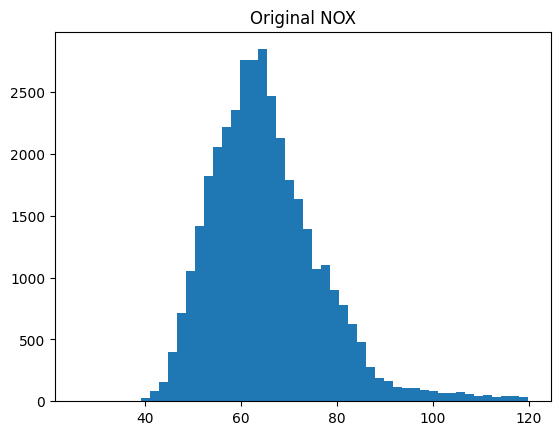

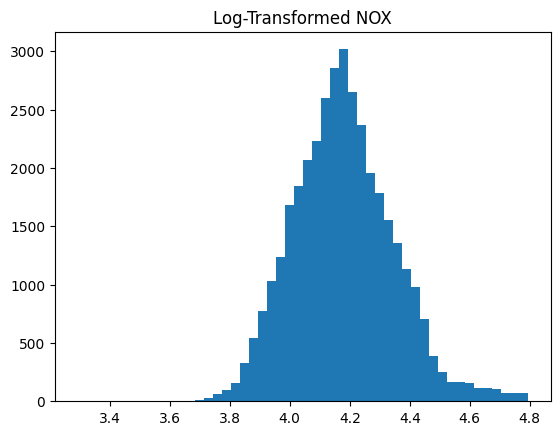

np.float64(0.3855580464350517)

In [7]:
import numpy as np

plt.figure()
plt.hist(df['NOX'], bins=50)
plt.title("Original NOX")
plt.show()

df['NOX_log'] = np.log1p(df['NOX'])

plt.figure()
plt.hist(df['NOX_log'], bins=50)
plt.title("Log-Transformed NOX")
plt.show()

df['NOX_log'].skew()


## Log Transformation of NOx

To reduce skewness and improve model stability, a log transformation was applied:

NOX_log = log(1 + NOX)

After transformation:

- Skewness reduced significantly
- Distribution became closer to normal
- Linear model assumptions improved

This step is particularly important when working with regression models.


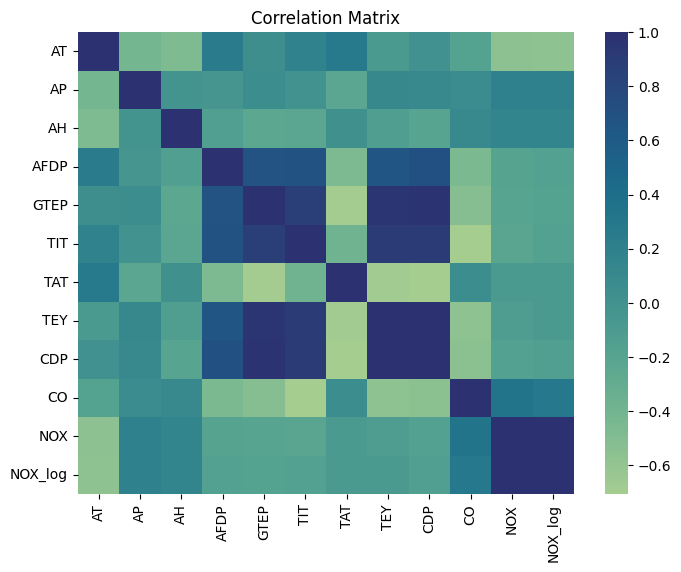

In [8]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=False, cmap="crest")
plt.title("Correlation Matrix")
plt.show()


## Correlation Analysis

The correlation matrix provides initial insight into linear relationships.

Key observations:

- Ambient Temperature (AT) shows noticeable correlation with NOx.
- Turbine Inlet Temperature (TIT) appears influential.
- No extreme multicollinearity (>0.8) detected among features.

This suggests that while relationships exist, non-linear behavior is likely.


In [9]:
x = df.drop(columns=['NOX','CO'])
y = df['NOX']

x.shape, y.shape

((36726, 10), (36726,))

## Preventing Data Leakage

During feature selection, care was taken to avoid data leakage.

The target variable (NOX_log) was excluded from feature inputs.

Additionally, CO emission was removed from the feature set to simulate a realistic operational scenario where NOx must be predicted from sensor data alone.

Avoiding leakage ensures that model performance reflects true predictive capability.


In [10]:
X = df.drop(columns=['NOX', 'NOX_log', 'CO'])
y = df['NOX_log']

X.shape, y.shape


((36726, 9), (36726,))

## Baseline Model: Linear Regression

Linear regression is used as a reference model,If performance is limited, it suggests non-linear dynamics.

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression


model = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("R2 mean:", r2_scores.mean())
print("R2 std:", r2_scores.std())
print("RMSE mean:", rmse_scores.mean())

R2 mean: 0.5353797191535117
R2 std: 0.011061014871083909
RMSE mean: 0.11497321918302346


### Results – Linear Regression

R² ≈ 0.53
Interpretation:
The linear model explains approximately 53% of the variance in NOx emissions.
This indicates that the system likely contains significant non-linear interactions.

## Non-Linear Model: Random Forest
This model tests whether combustion dynamics are non-linear.

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

r2_rf = cross_val_score(rf, X, y, cv=cv, scoring='r2')
rmse_rf = np.sqrt(-cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("RF R2 mean:", r2_rf.mean())
print("RF R2 std:", r2_rf.std())
print("RF RMSE mean:", rmse_rf.mean())


RF R2 mean: 0.8743100420905471
RF R2 std: 0.004680041241925178
RF RMSE mean: 0.05979665618682456


### Results – Random Forest
R² ≈ 0.87
Interpretation:
The large improvement over the linear baseline confirms strong non-linear behavior in emission dynamics.
Random Forest captures complex interaction effects that linear regression cannot.

## Feature Importance Analysis

Understanding which variables drive emissions is critical for industrial interpretability.

Feature importance helps identify dominant emission drivers.

In [13]:
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

importances


AT      0.405863
TIT     0.145225
GTEP    0.098005
TAT     0.095778
AFDP    0.078769
TEY     0.051322
AH      0.049110
CDP     0.038430
AP      0.037497
dtype: float64

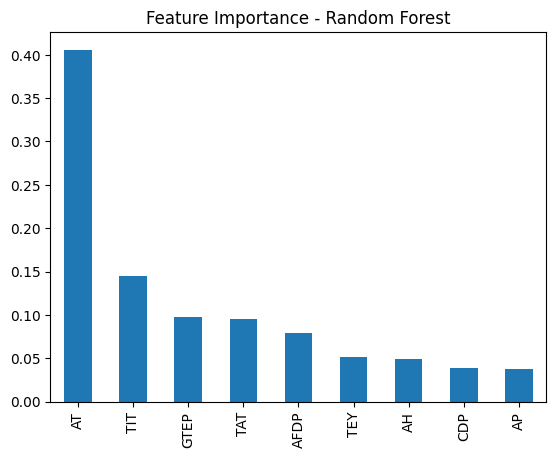

In [23]:
plt.figure()
importances.plot(kind='bar')
plt.title('Feature Importance - Random Forest')
plt.show()

### Interpretation

Ambient Temperature (AT) and Turbine Inlet Temperature (TIT) emerged as dominant contributors.

This aligns with combustion thermodynamics, where temperature significantly influences NOx formation.

## Model Interpretability with SHAP

While feature importance shows magnitude, SHAP explains direction of influence, local vs global impact and
Interaction patterns.

This step ensures the model aligns with physical intuition.

In [15]:
import shap
# Subset
X_sample = X.sample(500, random_state=42)

rf.fit(X, y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)


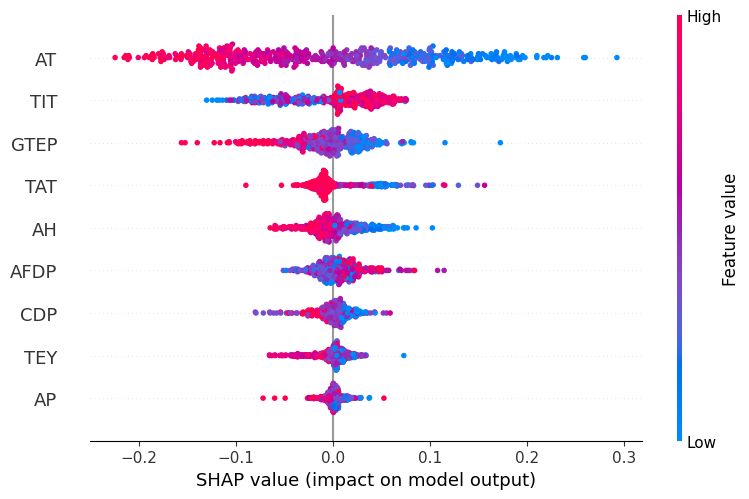

In [16]:
shap.summary_plot(shap_values, X_sample)

### SHAP Insights

- Higher TIT increases NOx emissions.
- Ambient conditions significantly impact emission levels.
- Non-linear thresholds are present in emission dynamics.

The ML findings are consistent with physical combustion principles.

## Global Sensitivity Analysis – Partial Dependence

Partial Dependence Plots (PDP) show the average effect of a feature on the predicted outcome.

Unlike SHAP, which provides local explanations, PDP illustrates global trends.

This helps verify whether model behavior aligns with engineering expectations.

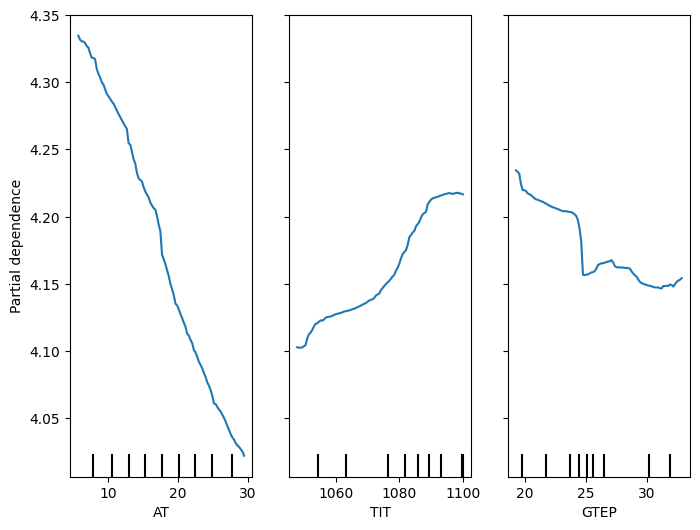

In [17]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['AT', 'TIT', 'GTEP']

fig, ax = plt.subplots(figsize=(8,6))
PartialDependenceDisplay.from_estimator(
    rf, X, features_to_plot, ax=ax
)
plt.show()

### Interpretation of Partial Dependence

- Increasing TIT results in higher predicted NOx emissions.
- Ambient Temperature shows a monotonic relationship with emissions.
- The curves confirm non-linear emission behavior.

The PDP results support the hypothesis that combustion temperature is a dominant driver of NOx formation.

In [18]:

bounds = {col: (X[col].min(), X[col].max()) for col in X.columns}

n_samples = 5000

rand_data = pd.DataFrame({
    col: np.random.uniform(low=bounds[col][0],
                           high=bounds[col][1],
                           size=n_samples)
    for col in X.columns
})

pred_log = rf.predict(rand_data)

pred_nox = np.expm1(pred_log)

rand_data['pred_NOX'] = pred_nox


In [19]:
best_case = rand_data.sort_values('pred_NOX').iloc[0]
best_case


AT            35.431968
AP          1002.981282
AH            84.329004
AFDP           3.327412
GTEP          23.123581
TIT         1053.136032
TAT          537.279164
TEY          131.441886
CDP           13.630142
pred_NOX      41.675594
Name: 1143, dtype: float64

In [20]:
df['TEY'].describe()

count    36726.000000
mean       133.506079
std         15.619558
min        100.020000
25%        124.450000
50%        133.730000
75%        144.080000
max        179.500000
Name: TEY, dtype: float64

In [21]:

tey_threshold = df['TEY'].quantile(0.75)

pareto_candidates = rand_data[
    (rand_data['pred_NOX'] <= rand_data['pred_NOX'].quantile(0.10)) &  
    (rand_data['TEY'] >= tey_threshold)                                 
]

pareto_candidates.sort_values('pred_NOX').head()


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,pred_NOX
3745,32.026719,986.846698,86.123967,3.226209,39.769648,1008.316785,543.093586,148.018264,14.634617,42.322222
2284,34.012422,1001.865957,88.481774,2.809061,32.893226,1006.197069,525.423495,154.904816,11.547233,42.460377
2479,29.155361,989.279928,90.025606,3.620257,27.597865,1035.040294,549.341205,144.120497,13.622844,42.628288
3662,30.111834,996.129324,82.389637,2.825215,34.484718,1030.976600,539.397833,152.690602,11.673081,42.637166
3350,32.860962,1002.551822,87.666439,3.923773,29.324067,1047.662720,531.261956,152.502823,14.826688,42.696223


## Gradient Boosting Model: XGBoost

XGBoost is tested to evaluate whether boosting methods further improve performance.

Boosting sequentially corrects model errors and often performs well on structured tabular data.

In [22]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

r2_xgb = cross_val_score(xgb, X, y, cv=cv, scoring='r2')
rmse_xgb = np.sqrt(-cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("XGBoost R2 mean:", r2_xgb.mean())
print("XGBoost R2 std:", r2_xgb.std())
print("XGBoost RMSE mean:", rmse_xgb.mean())


XGBoost R2 mean: 0.8328336360397008
XGBoost R2 std: 0.0032255610425630243
XGBoost RMSE mean: 0.06896849667743563


### Results – XGBoost
R² ≈ 0.83
Interpretation:
Although XGBoost performs strongly, Random Forest achieved higher performance on this dataset.
This suggests that variance reduction through bagging was more beneficial than boosting.

# Modeling Summary

1. Linear regression provides limited explanatory power.
2. Random Forest significantly improves predictive performance.
3. Emission behavior is strongly non-linear.
4. Temperature-related variables dominate emission formation.
5. Model interpretability aligns with combustion physics.